In [9]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# load processed features/targets
x_train = pd.read_csv("archive/train/x_train.csv")
y_train = pd.read_csv("archive/train/y_train.csv").squeeze()

x_val = pd.read_csv("archive/val/x_val.csv")
y_val = pd.read_csv("archive/val/y_val.csv").squeeze()

# build and fit the model on the training set
elastic_net = Pipeline(
    steps=[
        ("scaler", StandardScaler(with_mean=False)),  # sparse-safe scaling
        ("model", ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
    ]
)

elastic_net.fit(x_train, y_train)

# validate on the hold-out validation set
val_pred = elastic_net.predict(x_val)

mae = mean_absolute_error(y_val, val_pred)
rmse = mean_squared_error(y_val, val_pred) ** 0.5  # old API; take sqrt manually
r2 = r2_score(y_val, val_pred)

print(f"Validation MAE:  {mae:,.2f}")
print(f"Validation RMSE: {rmse:,.2f}")
print(f"Validation R²:   {r2:.4f}")

Validation MAE:  27.07
Validation RMSE: 36.55
Validation R²:   0.2569


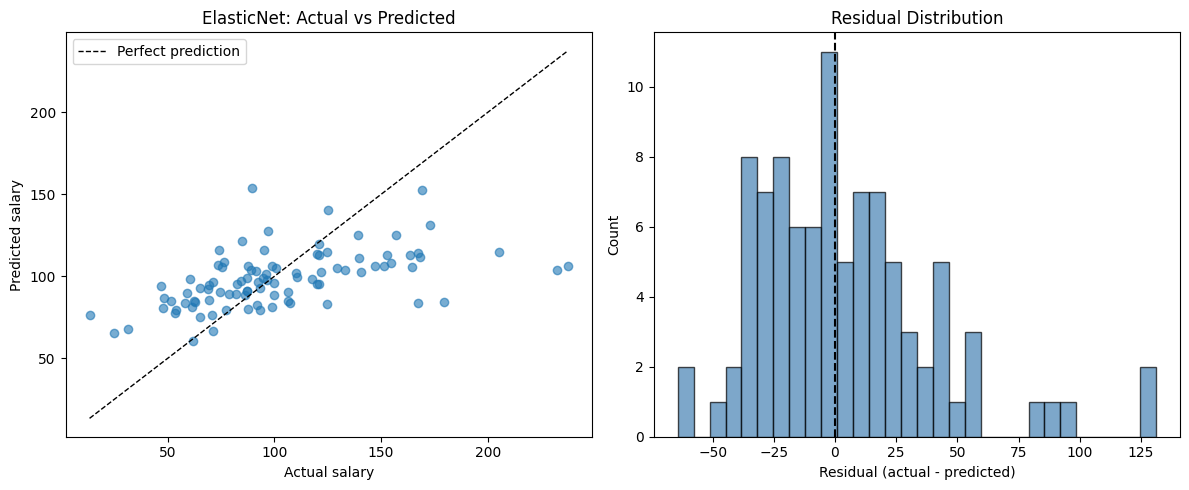

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Predicted vs actual (ideal is the dashed diagonal)
axes[0].scatter(y_val, val_pred, alpha=0.6)
axes[0].plot([y_val.min(), y_val.max()],
             [y_val.min(), y_val.max()],
             'k--', lw=1, label='Perfect prediction')
axes[0].set_xlabel('Actual salary')
axes[0].set_ylabel('Predicted salary')
axes[0].set_title('ElasticNet: Actual vs Predicted')
axes[0].legend()

# Residual histogram (should be tight and centered on zero)
residuals = y_val - val_pred
axes[1].hist(residuals, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='k', linestyle='--')
axes[1].set_xlabel('Residual (actual - predicted)')
axes[1].set_ylabel('Count')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

x_train = pd.read_csv("archive/train/x_train.csv")
y_train = pd.read_csv("archive/train/y_train.csv").squeeze()

pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler(with_mean=False)),
        ("model", ElasticNet(max_iter=10000, random_state=42))
    ]
)

param_grid = {
    "model__alpha": np.logspace(-2, 1, 6),        # 0.01 … 10
    "model__l1_ratio": np.linspace(0.1, 0.9, 5)   # 0.1 … 0.9
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

grid.fit(x_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV RMSE:", (-grid.best_score_) ** 0.5)

# optional: evaluate the tuned model on validation split
x_val = pd.read_csv("archive/val/x_val.csv")
y_val = pd.read_csv("archive/val/y_val.csv").squeeze()


best_model = grid.best_estimator_
val_pred = best_model.predict(x_val)
r2 = r2_score(y_val, val_pred)
val_rmse = mean_squared_error(y_val, val_pred) ** 0.5
print("Validation RMSE:", val_rmse)
print(f"Validation R²:   {r2:.4f}")


Best params: {'model__alpha': 0.630957344480193, 'model__l1_ratio': 0.9}
Best CV RMSE: 28.46445792953646
Validation RMSE: 35.38089054678447
Validation R²:   0.3037


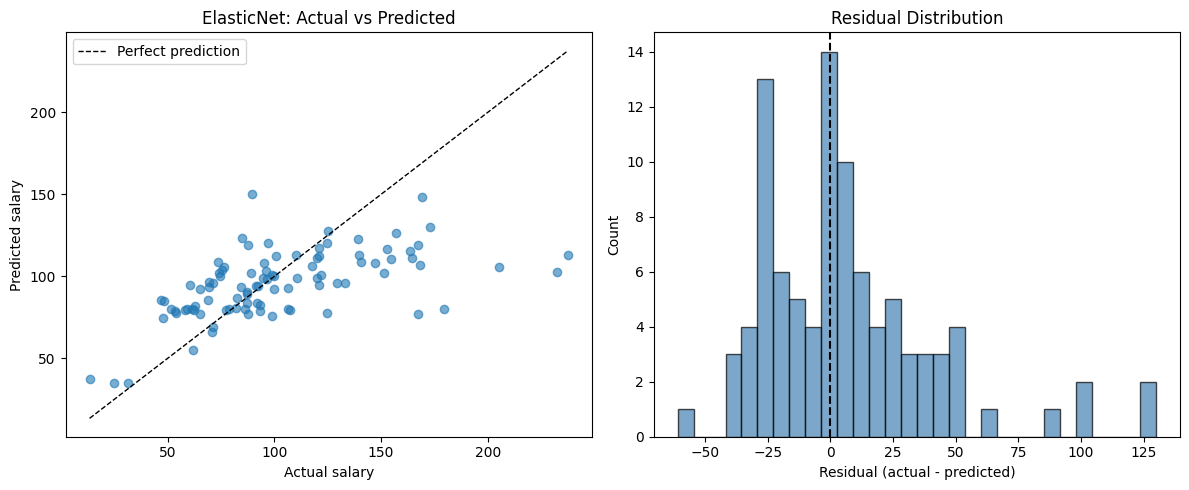

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Predicted vs actual (ideal is the dashed diagonal)
axes[0].scatter(y_val, val_pred, alpha=0.6)
axes[0].plot([y_val.min(), y_val.max()],
             [y_val.min(), y_val.max()],
             'k--', lw=1, label='Perfect prediction')
axes[0].set_xlabel('Actual salary')
axes[0].set_ylabel('Predicted salary')
axes[0].set_title('ElasticNet: Actual vs Predicted')
axes[0].legend()


# Residual histogram (should be tight and centered on zero)
residuals = y_val - val_pred
axes[1].hist(residuals, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='k', linestyle='--')
axes[1].set_xlabel('Residual (actual - predicted)')
axes[1].set_ylabel('Count')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()